In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. KHÁM PHÁ CÁC DÒNG VÀ CỘT

In [179]:
df = pd.read_csv("../data/cleaned/hcmhouseprice.csv")
df.head()

,price,area,bedrooms,bathrooms,address
0,20.6,58.1,1.0,1.0,quận 1
1,20.0,56.0,1.0,1.0,quận 1
2,8.9,51.0,1.0,1.0,quận 1
3,9.5,50.0,1.0,1.0,quận 1
4,10.2,48.0,1.0,1.0,quận 1


In [180]:
display(df.info())
display(df.describe())
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      2406 non-null   float64
 1   area       2406 non-null   float64
 2   bedrooms   2406 non-null   float64
 3   bathrooms  2406 non-null   float64
 4   address    2406 non-null   object 
dtypes: float64(4), object(1)
memory usage: 94.1+ KB


None

,price,area,bedrooms,bathrooms
count,2406.000000,2406.000000,2406.000000,2406.000000
mean,9.558039,121.006883,2.827930,2.497506
std,14.185876,1359.995744,3.412632,3.407677
min,0.001000,1.000000,1.000000,0.000000
25%,3.150000,65.000000,2.000000,2.000000
50%,5.400000,75.920000,2.000000,2.000000
75%,10.500000,100.000000,3.000000,2.000000
max,210.000000,66666.000000,60.000000,60.000000


price        0
area         0
bedrooms     0
bathrooms    0
address      0
dtype: int64

Dữ liệu gồm **2,406 dòng** và **không có giá trị khuyết (NaN)**.  
Tuy nhiên, quan sát thống kê mô tả cho thấy có nhiều **giá trị ngoại lệ (outlier)** ở các biến:

- `price` có giá trị cao nhất tới `210` (trong khi Q3 chỉ là `10.5`).  
- `area` có giá trị cực đại `66,666` - khả năng là lỗi cào dữ liệu.  
- `bedrooms` và `bathrooms` có giá trị lên tới `60`, vượt xa thực tế.  

Những giá trị này không phản ánh đúng dữ liệu thực tế, nên **cần loại bỏ** để đảm bảo chất lượng mô hình.

# 2. LÀM SẠCH DỮ LIỆU

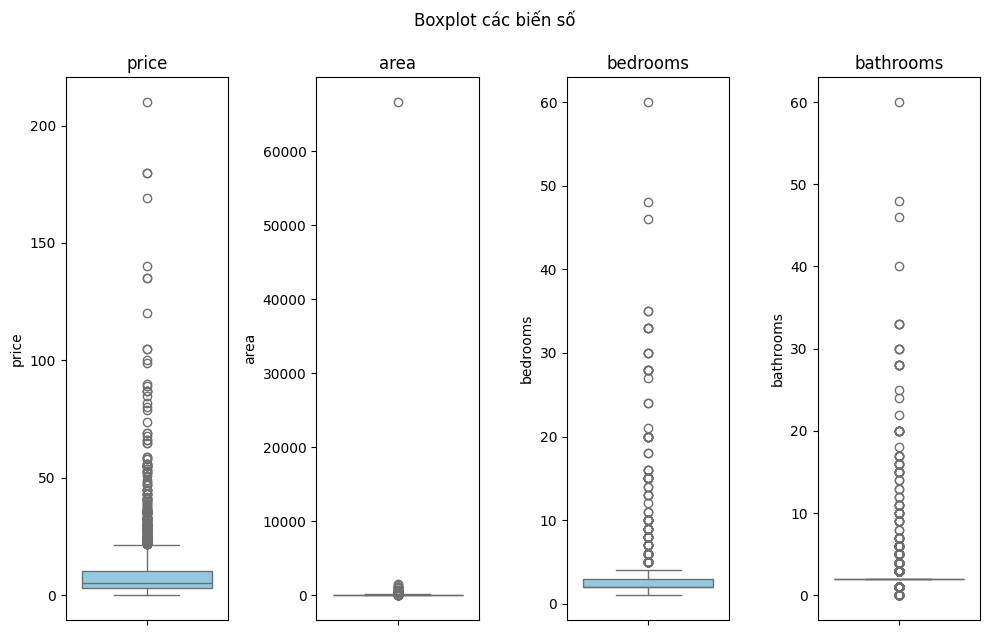

In [181]:
num_cols = ['price', 'area', 'bedrooms', 'bathrooms']

plt.figure(figsize=(10,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplot các biến số", y=1.05)
plt.show()

Đúng như dự đoán, các **giá trị ngoại lai (outlier)** xuất hiện khá nhiều, vì vậy bắt đầu tiến hành **sàng lọc dữ liệu** để loại bỏ những điểm bất thường.
Tuy nhiên, các outlier vẫn có thể xuất hiện do sự phân bố giá nhà rất khác nhau giữa các khu vực. 

Do đó, để kiểm tra chi tiết hơn, chúng em sẽ tập trung vào **boxplot của `price`** nhằm quan sát sự phân bố.

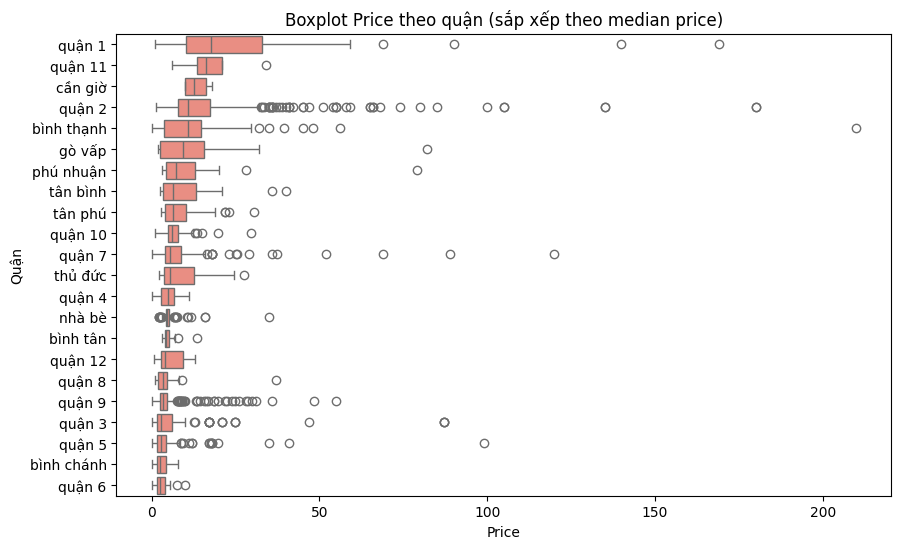

In [182]:
median_by_address = df.groupby('address')['price'].median().sort_values(ascending=False)
sorted_addresses = median_by_address.index.tolist()

plt.figure(figsize=(10,6))
sns.boxplot(
    y='address',
    x='price',
    data=df,
    order=sorted_addresses,
    color='salmon'
)
plt.xlabel("Price")
plt.ylabel("Quận")
plt.title("Boxplot Price theo quận (sắp xếp theo median price)")
plt.show()

Quan sát boxplot và phân bố giá theo quận cho thấy:  
- Các **outlier chỉ xuất hiện ở một số quận nhất định**.  
- Khoảng cách giữa các **median price/area/bedrooms/bathrooms** giữa các quận khá lớn.

Để lọc dữ liệu hiệu quả và đảm bảo mô hình không bị nhiễu bởi các giá trị bất thường,  
chúng em áp dụng **phương pháp IQR (Interquartile Range)** cho từng biến số:

- Tính Q1 (25%) và Q3 (75%) cho mỗi biến.  
- Xác định IQR = Q3 - Q1.  
- Giữ lại các giá trị nằm trong khoảng `[Q1 - 1.5*IQR, Q3 + 1.5*IQR]`.  

Sau bước này, dữ liệu còn lại sẽ **loại bỏ các outlier cục bộ**, giúp phân tích và mô hình hóa chính xác hơn.

In [183]:
def remove_outlier_iqr_fixed(df, cols):
    df_out = df.copy()

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]

    return df_out

num_cols = ['price', 'area', 'bedrooms', 'bathrooms']

print(f"Số dòng trước khi lọc: {len(df)}")
df = remove_outlier_iqr_fixed(df, num_cols)
print(f"Số dòng sau khi lọc: {len(df)}")

Số dòng trước khi lọc: 2406
Số dòng sau khi lọc: 1453


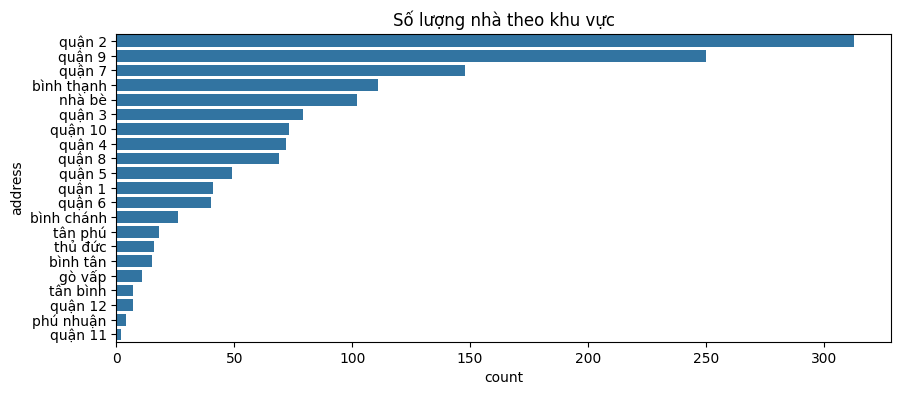

In [184]:
plt.figure(figsize=(10,4))
sns.countplot(y='address', data=df, order=df['address'].value_counts().index)
plt.title("Số lượng nhà theo khu vực")
plt.show()


Quan sát dữ liệu qua **EDA** cho thấy sự phân bố mẫu giữa các quận không đồng đều:  
một số quận như **Cần Giờ, Gò Vấp, Thủ Đức, Tân Bình, Phú Nhuận, Quận 12, Quận 11** chỉ có **số lượng mẫu rất ít**, không đủ đại diện để mô hình học chính xác các mối quan hệ giữa `price`, `area`, `bedrooms` và `bathrooms`.  

Nếu giữ lại các quận này:
- Mô hình có thể **học kém** về các quận đó do thiếu dữ liệu.  
- Ngoại lệ hoặc dữ liệu ít có thể **gây nhiễu**, làm tăng sai số dự đoán.  

Do đó, để **tối ưu chất lượng dự đoán và tránh overfitting trên các quận có ít dữ liệu**, chúng em quyết định **loại bỏ các quận này** và tập trung phân tích trên các quận có **số lượng mẫu đủ lớn** theo tiêu chí `số mẫu < 10`

In [185]:
counts = df['address'].value_counts()

valid_addresses = counts[counts >= 10].index.tolist()

df_filtered = df[df['address'].isin(valid_addresses)].copy()

print("Số mẫu còn lại theo quận (>=10 mẫu):")
display(df_filtered['address'].value_counts())

df = df_filtered.copy()

Số mẫu còn lại theo quận (>=10 mẫu):


address
quận 2        313
quận 9        250
quận 7        148
bình thạnh    111
nhà bè        102
quận 3         79
quận 10        73
quận 4         72
quận 8         69
quận 5         49
quận 1         41
quận 6         40
bình chánh     26
tân phú        18
thủ đức        16
bình tân       15
gò vấp         11
Name: count, dtype: int64

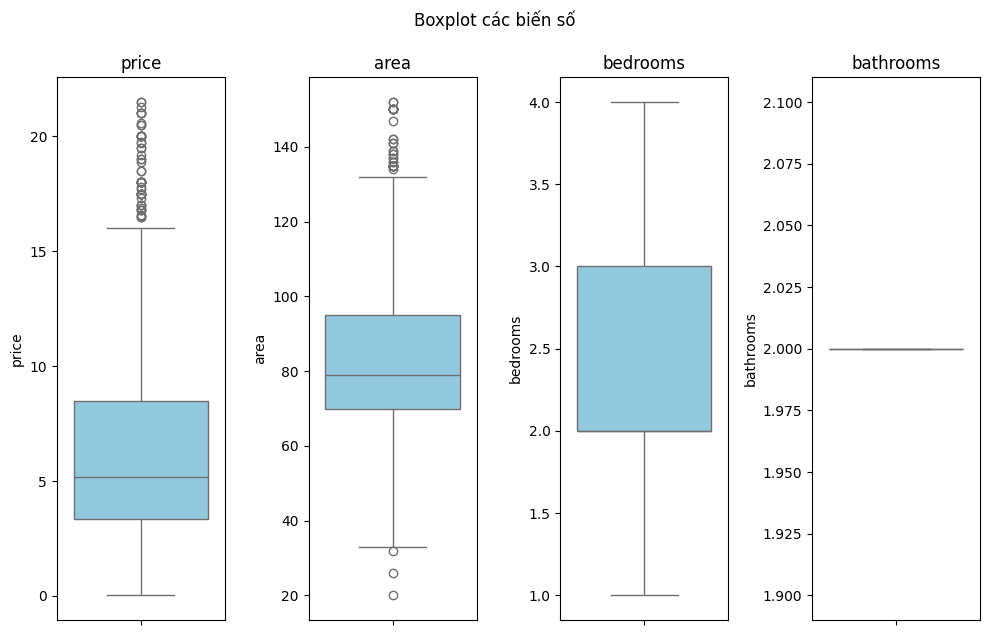

In [186]:
num_cols = ['price', 'area', 'bedrooms', 'bathrooms']

plt.figure(figsize=(10,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplot các biến số", y=1.05)
plt.show()

Sau lần sàng lọc đầu tiên, các giá trị `outlier` của các biến như `area`, `bedrooms` và `bathrooms` đã nằm trong mức **có thể chấp nhận được**, trong khi `price` vẫn còn một số điểm bất thường có thể gây nhiễu cho mô hình.

Mặc dù các outlier có thể ảnh hưởng tiêu cực đến mô hình, việc **lọc quá mạnh** để loại bỏ mọi điểm bất thường có thể dẫn đến **mất một lượng lớn dữ liệu quan trọng**, đặc biệt là các quận hoặc phân khúc nhà có giá cao, diện tích lớn.

Nếu lọc quá nghiêm ngặt, mô hình sẽ **thiếu dữ liệu để học**, tăng nguy cơ **underfitting** và không phản ánh đúng **phân bố thực tế của thị trường**. Do đó sẽ sử dụng bộ dữ liệu này để tiến hành phân tích và huấn luyện.

# 3. PHÂN TÍCH DỮ LIỆU

,address,median_price_per_m2
0,quận 1,0.137500
1,quận 2,0.110781
2,bình thạnh,0.101220
3,quận 7,0.075714
4,quận 10,0.072963
5,tân phú,0.067819
6,nhà bè,0.063333
7,quận 4,0.061481
8,thủ đức,0.057353
9,bình tân,0.056250


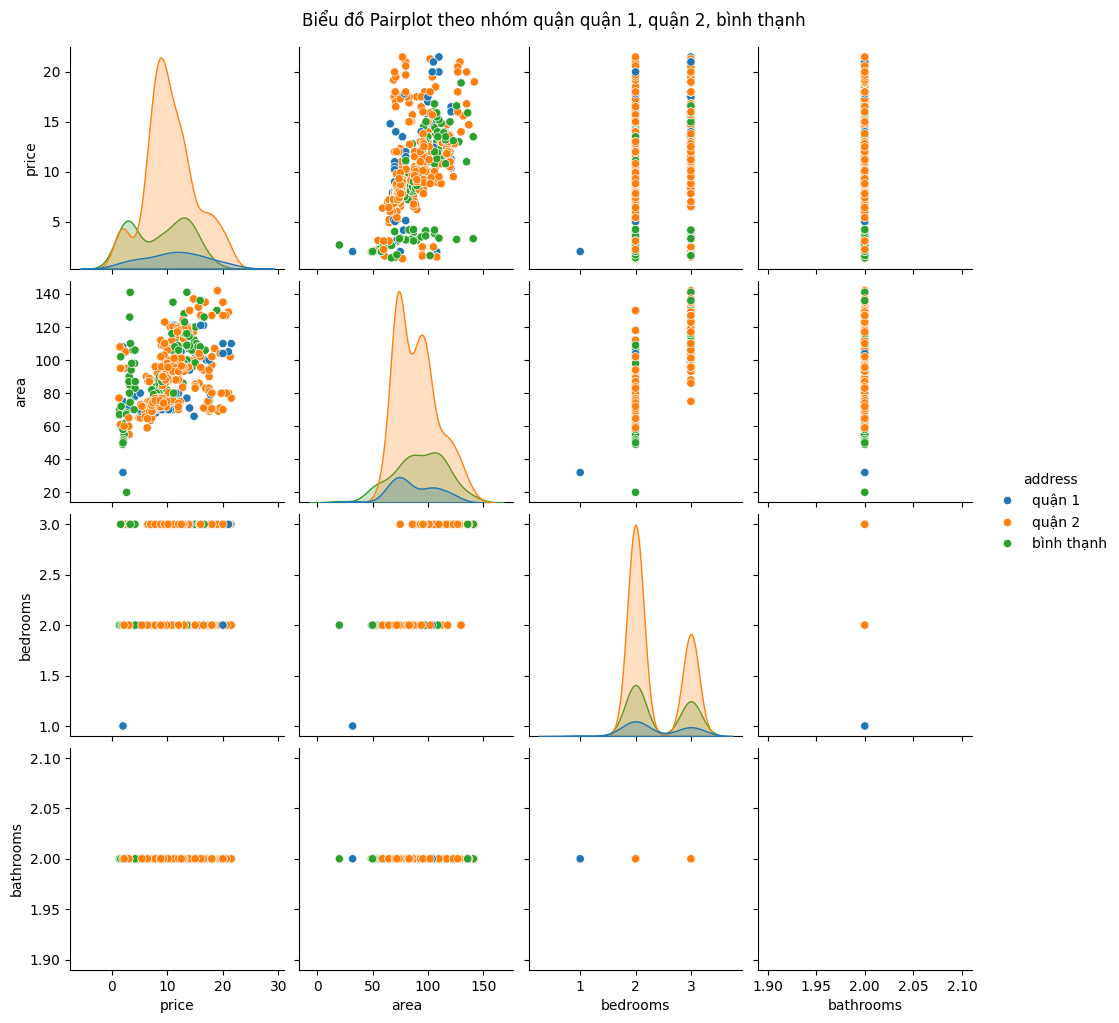

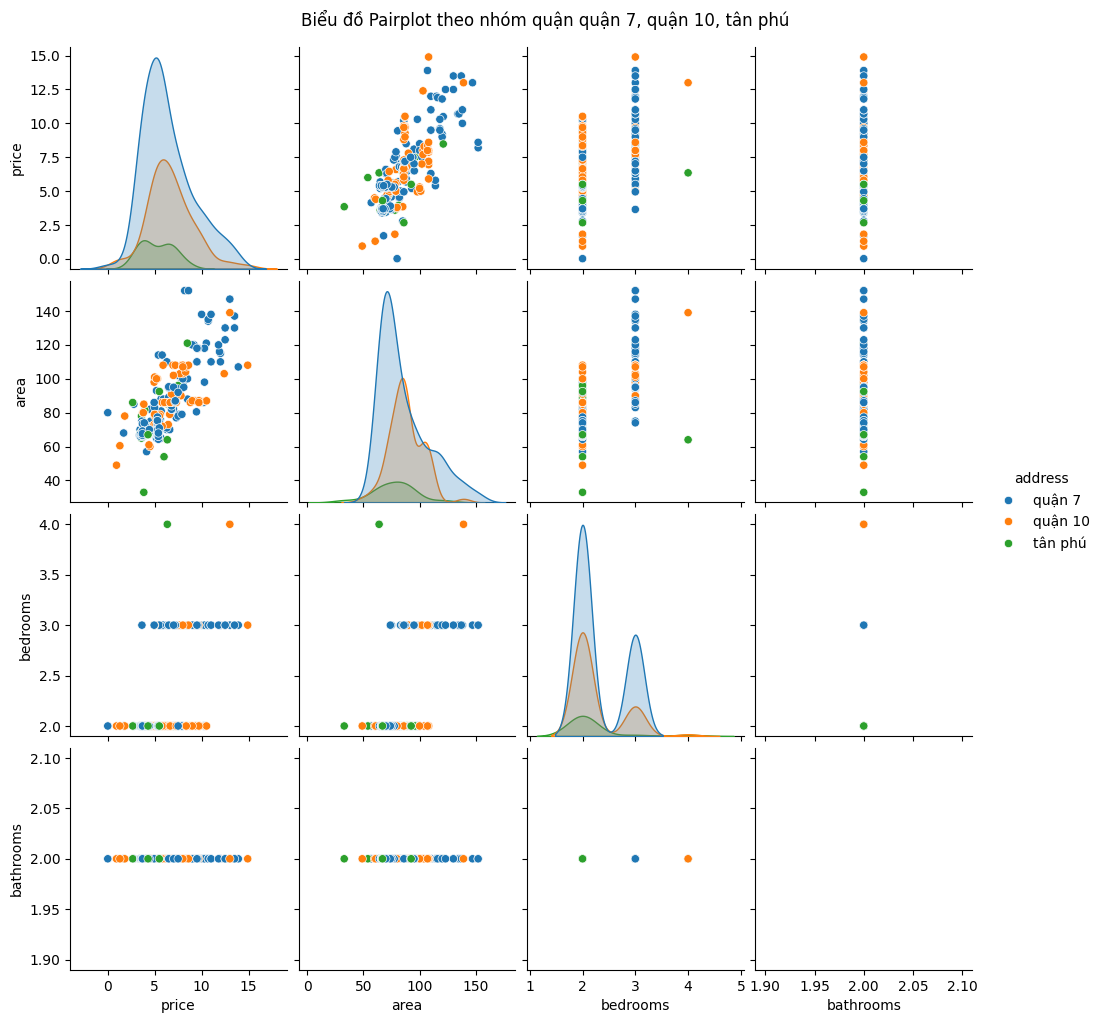

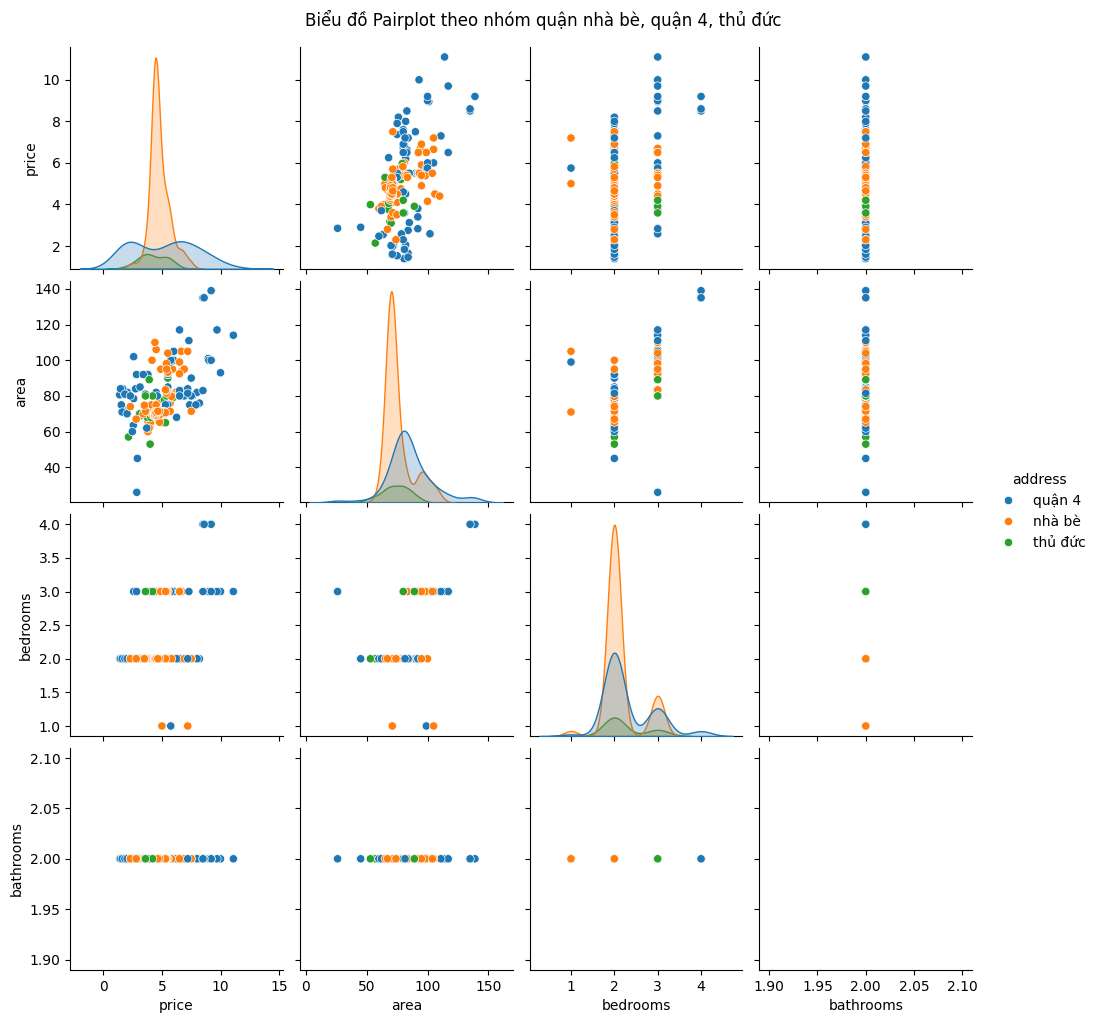

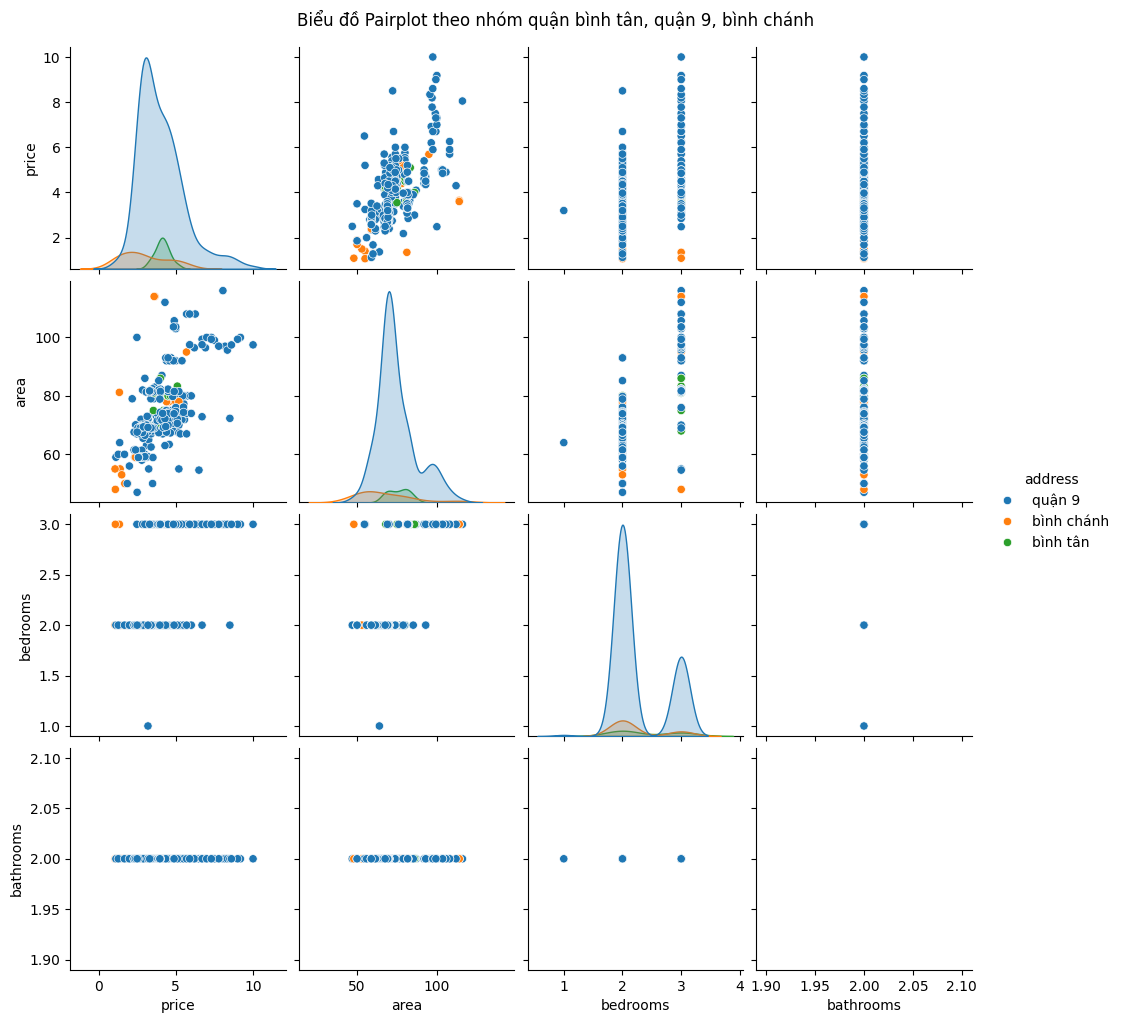

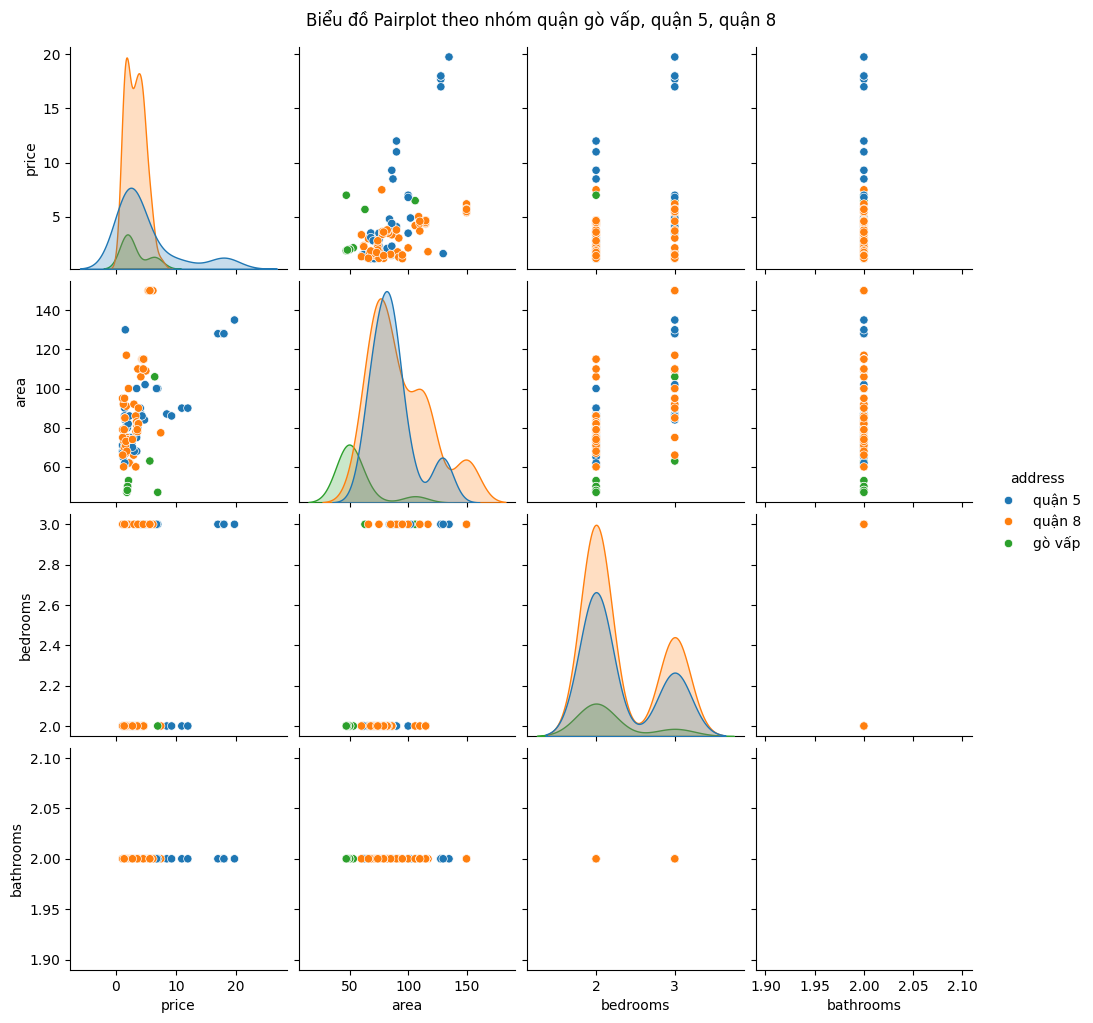

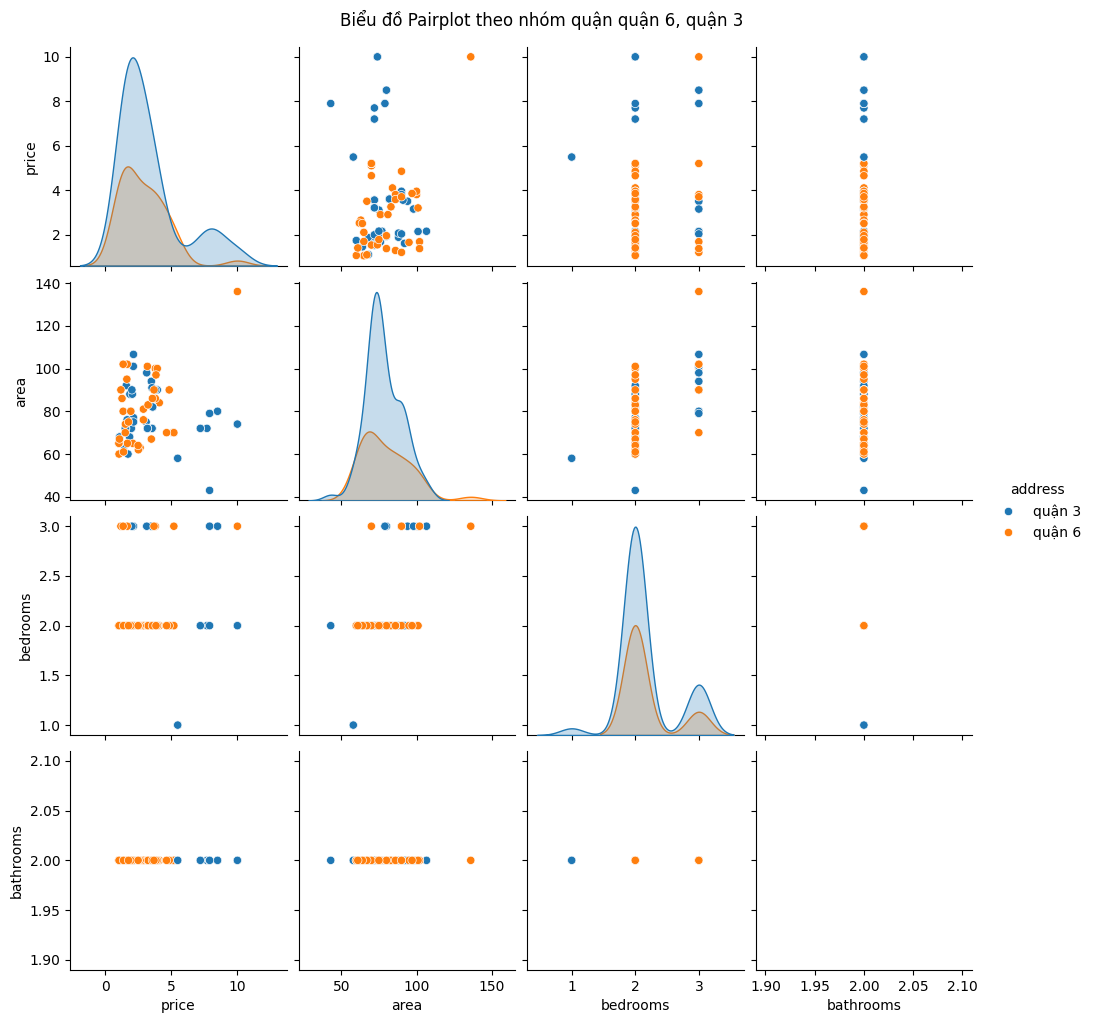

In [187]:
df['price_per_m2'] = df['price'] / df['area']

median_by_address = (
    df.groupby('address')['price_per_m2']
    .median()
    .sort_values(ascending=False)
    .reset_index()
)
median_by_address.columns = ['address', 'median_price_per_m2']
display(median_by_address)

addresses = median_by_address['address'].tolist()

for i in range(0, len(addresses), 3):
    group = addresses[i:i+3]
    df_group = df[df['address'].isin(group)]

    sns.pairplot(
        df_group,
        vars=['price', 'area', 'bedrooms', 'bathrooms'],
        hue='address',
        palette='tab10'
    )
    plt.suptitle(f"Biểu đồ Pairplot theo nhóm quận {', '.join(group)}", y=1.02)
    plt.show()

Sau khi chia dữ liệu theo từng nhóm **3 quận** và vẽ pairplot:

- **Mối quan hệ giữa `area` và các biến khác** (`price`, `bedrooms`, `bathrooms`) gần như **tuyến tính** trong từng quận.  
  → Điều này cho thấy **giá nhà và số phòng/tầng tăng theo diện tích** khá ổn định trong mỗi quận.  

- **Sự phân bố giữa các nhóm quận** cũng rất rõ rệt:  
  - Các quận có **giá trung vị/m2 cao** như `Quận 1`, `Quận 2`, `Bình Thạnh` tập trung ở **vùng giá và diện tích cao**.  
  - Các quận giá thấp hơn như `Quận 3`, `Quận 6`, `Quận 8` tập trung ở **vùng giá và diện tích thấp hơn**.  

- Top quận theo median price/m2 từ cao xuống thấp:

| Quận       | Median price/m2|
|------------|----------------|
| Quận 1     | 0.137500       |
| Quận 2     | 0.110781       |
| Bình Thạnh | 0.101220       |
| Quận 7     | 0.075714       |
| Quận 10    | 0.072963       |
| Tân Phú    | 0.067819       |
| Nhà Bè     | 0.063333       |
| Quận 4     | 0.061481       |
| Thủ Đức    | 0.057353       |
| Bình Tân   | 0.056250       |
| Quận 9     | 0.049329       |
| Bình Chánh | 0.043898       |
| Gò Vấp     | 0.040000       |
| Quận 5     | 0.040000       |
| Quận 8     | 0.037903       |
| Quận 6     | 0.036901       |
| Quận 3     | 0.028733       |

**Kết luận:**  
- Dữ liệu cho thấy **mối quan hệ tuyến tính giữa diện tích và các biến khác** (`price`, `bedrooms`, `bathrooms`) khá đồng nhất trong từng quận.  
- **Sự khác biệt rõ rệt giữa các quận** chứng tỏ việc **xếp nhóm theo khu vực** là hợp lý khi phân tích và xây dựng mô hình dự đoán giá nhà.

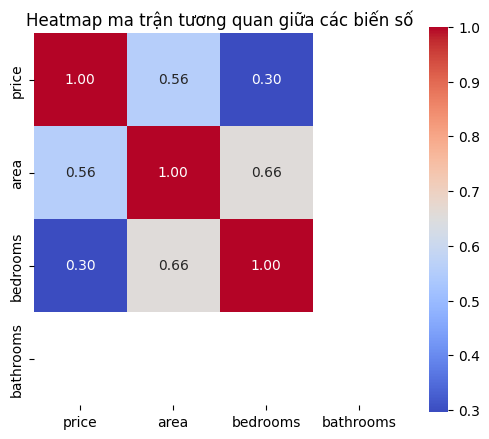

In [193]:
num_cols = ['price', 'area', 'bedrooms', 'bathrooms']
corr_matrix = df_filtered[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True,
    square=True
)
plt.title("Heatmap ma trận tương quan giữa các biến số")
plt.show()



Heatmap ma trận tương quan giữa các biến số cho thấy:
- Mức tương quan giữa `area` và `bedrooms` không quá cao,  
- Đặc biệt, `bathrooms` có nhiều giá trị bằng 0, làm giảm mức tương quan với các biến khác.  
Như vậy, có thể nhận xét rằng **các biến số này phần lớn độc lập với nhau**, không ảnh hưởng mạnh lẫn nhau. Điều này sẽ giúp mô hình học được **mối quan hệ riêng biệt giữa mỗi biến và giá nhà** mà không bị nhiễu từ các biến còn lại.

In [190]:
output_path = "../data/cleaned/hcmhouseprice_filtered.csv"
df_filtered.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Đã lưu dữ liệu đã lọc vào: {output_path}")

Đã lưu dữ liệu đã lọc vào: ../data/cleaned/hcmhouseprice_filtered.csv
